In [34]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
import zipfile
from datetime import datetime
from dateutil import parser
import datetime
import ast
import json
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns
from OGDUtils.general.fileio import FileAPI, FileTypes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Retrieve Data Files

#### Please change the settings below to configure which game/server location you want to use.

<!-- `ogd_server` : The file server that contains the actual data files -->
* `game_id` : The game whose data you want to access.
* `mode` : The kind of data you want to retrieve. Should be one of `FileTypes.PLAYER`, `FileTypes.POPULATION`, `FileTypes.SESSION`, `FileTypes.EVENTS` or `FileTypes.ALL_EVENTS`

In [ ]:
game_id = 'JOURNALISM'
mode    = FileTypes.PLAYER

In [ ]:
months_list = FileAPI.GetAvailableMonths(game_id)
print(f"The available months are:")
pprint(months_list, compact=True)

The available months are:
['3/2019', '4/2019', '5/2019', '6/2019', '7/2019', '8/2019', '9/2019',
 '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020',
 '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020',
 '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021',
 '7/2021', '8/2021', '9/2021', '10/2021', '11/2021', '12/2021', '1/2022',
 '2/2022', '3/2022', '4/2022', '5/2022', '6/2022', '7/2022', '8/2022', '9/2022',
 '10/2022', '11/2022', '12/2022', '1/2023', '2/2023', '3/2023', '4/2023',
 '5/2023', '6/2023', '7/2023', '8/2023']


In [ ]:
month = 2
year = 2023

# download the file if it doesn't exist.
# zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)
# zip_name = zip_file.filename

Found the file AQUALAB_20230201_to_20230228_5de1a1f_events.zip locally, nothing will be downloaded.


#### Import Data Files to Jupyter

In [ ]:
raw_data = pd.DataFrame()

###
#  To use file(s) from website, uncomment the lines in previous cell and delete these.
file_path = 'JOURNALISM_20230401_to_20230425_7e4c492_player-features.zip'
dataset_name = 'JOURNALISM_20230401_to_20230425'
zip_file = ZipFile(file_path)
zip_name = zip_file.filename
###

MAX_ROWS = 10000 # for the sake of not overwhelming RAM, only read first 10,000 rows of a file. Feel free to increase

# Open TSV from the zip file.
tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t', nrows=MAX_ROWS)
    data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

In [36]:
df_session = raw_data.dropna()
for col in df_session.columns:
    dtype = df_session[col].dtype
    if dtype == bool:
        # convert the boolean column to integer (1 for True and 0 for False)
        df_session[col] = df_session[col].astype(int)

def convert_to_seconds(time_str):
    try:
        time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S.%f').time()
        timedelta_obj = datetime.timedelta(hours=time_obj.hour, minutes=time_obj.minute, seconds=time_obj.second, microseconds=time_obj.microsecond)
        return timedelta_obj.total_seconds()
    except ValueError:
        return None

df_session['UserPlayTime'] = df_session['UserPlayTime'].apply(convert_to_seconds)
df_session['UserPlayTime-Total Time'] = df_session['UserPlayTime-Total Time'].apply(convert_to_seconds)


<ipython-input-36-c796eb813517>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-c796eb813517>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-c796eb813517>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BetweenLevels     5
OnFail           23
Other            67
Name: QuitType, dtype: int64
BetweenLevels    0
OnFail           1
Other            6
Name: QuitType, dtype: int64
BetweenLevels     0
OnFail            3
Other            21
Name: QuitType, dtype: int64
BetweenLevels    0
OnFail           0
Other            2
Name: QuitType, dtype: int64
BetweenLevels     0
OnFail            2
Other            10
Name: QuitType, dtype: int64


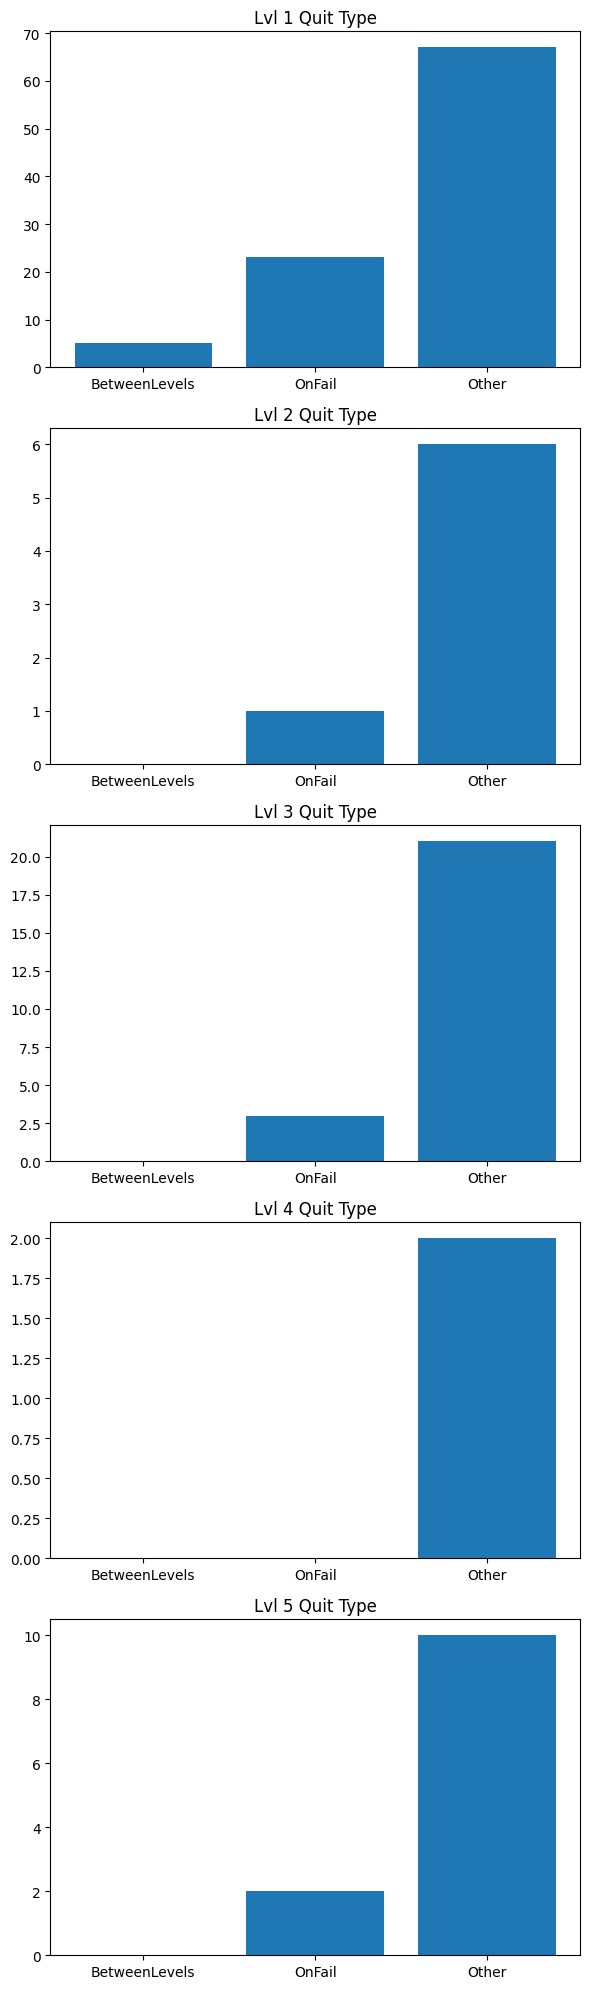

In [37]:
quit_types = sorted(df_session['QuitType'].unique())
fig, axs = plt.subplots(5, 1, figsize=(6, 20))

bins = 3
x_ticks = np.arange(len(quit_types))
x_tick_labels = quit_types

for i, ax in enumerate(axs):
    fail_level = i + 1
    fail_data = df_session[df_session[f'lvl{fail_level}_FailureCount'] > 0]
    df_column = fail_data['QuitType']
    quit_type_counts = df_column.value_counts().reindex(quit_types, fill_value=0)
    print(quit_type_counts)
    ax.bar(x_ticks, quit_type_counts, align='center')
    ax.set_title(f"Lvl {fail_level} Quit Type")

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

fig.tight_layout()
plt.show()

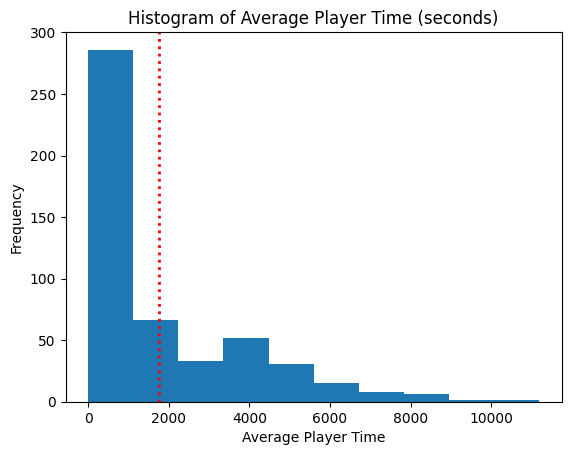

Average time: 29.40090003340013 minutes


In [38]:
plt.hist(df_session['UserPlayTime'], bins=10)
plt.axvline(x=df_session['UserPlayTime'].mean(), color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Average Player Time')
plt.ylabel('Frequency')
plt.title('Histogram of Average Player Time (seconds)')
plt.show()
print(f'Average time: {df_session["UserPlayTime"].mean() / 60} minutes')

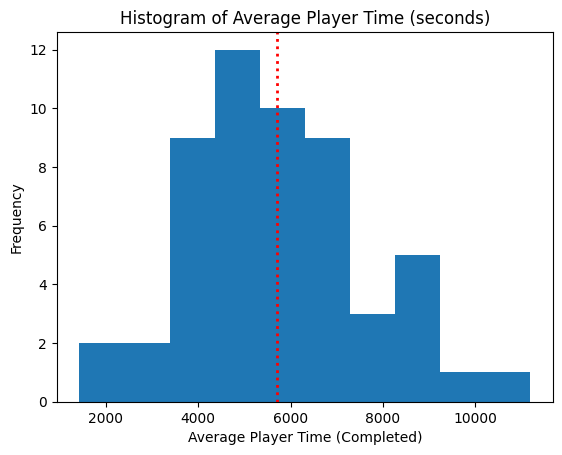

Average time: 95.08479845679012 minutes


In [39]:
df_completed = df_session[df_session['GameComplete'] == 1]
plt.hist(df_completed['UserPlayTime'], bins=10)
plt.axvline(x=df_completed['UserPlayTime'].mean(), color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Average Player Time (Completed)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Player Time (seconds)')
plt.show()
print(f'Average time: {df_completed["UserPlayTime"].mean() / 60} minutes')

In [40]:
df_played_well = df_session[df_session['TotalFails'] < 50 ]
json_str = df_played_well['SkillSequenceCount-Event Sequence']
parsed_json_object_1 = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_object_1.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_object_1:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Well Played Games'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig

{'Research': 0.46680080482897385, 'Resourceful': 1.5895372233400402, 'Endurance': 1.5271629778672031, 'Tech': 1.3018108651911469, 'Social': 1.0543259557344065, 'Trust': 1.1770623742454729}


In [41]:
json_str = df_completed['SkillSequenceCount-Event Sequence']
parsed_json_objects = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_objects.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_objects:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Completed Games'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig

{'Research': 4.907407407407407, 'Resourceful': 8.814814814814815, 'Endurance': 18.74074074074074, 'Tech': 9.796296296296296, 'Social': 6.277777777777778, 'Trust': 5.777777777777778}


In [42]:
df_no_finish = df_session[df_session['GameComplete'] == 0]
json_str = df_no_finish['SkillSequenceCount-Event Sequence']
parsed_json_objects = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_objects.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_objects:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Games that were not Completed'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig


{'Research': 0.37303370786516854, 'Resourceful': 1.355056179775281, 'Endurance': 1.0853932584269663, 'Tech': 1.0179775280898877, 'Social': 0.9258426966292135, 'Trust': 1.002247191011236}


In [43]:
len(df_completed)

54

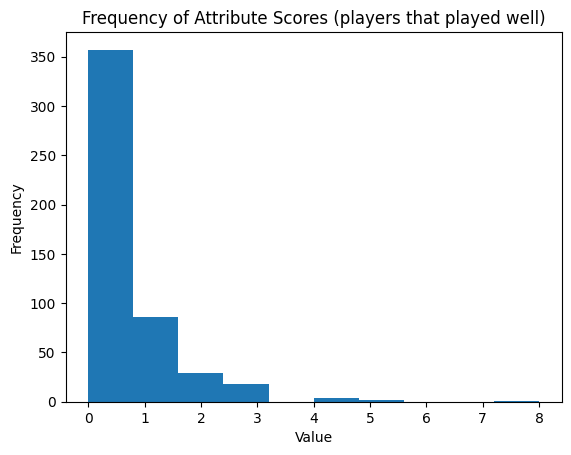

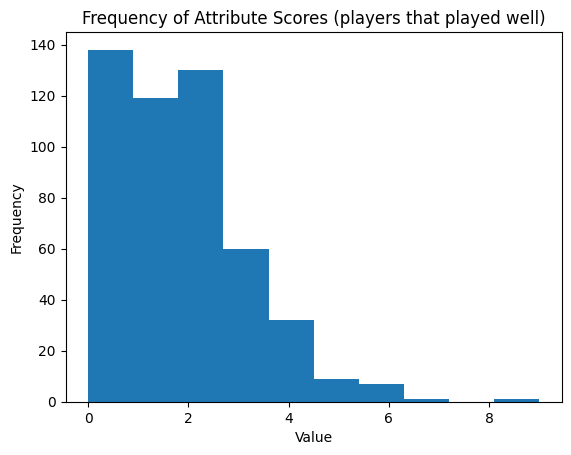

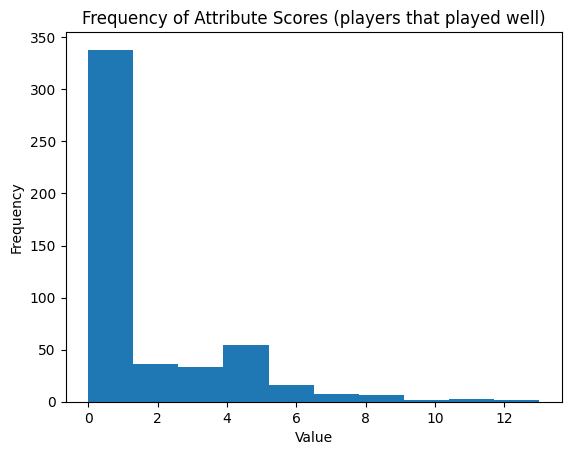

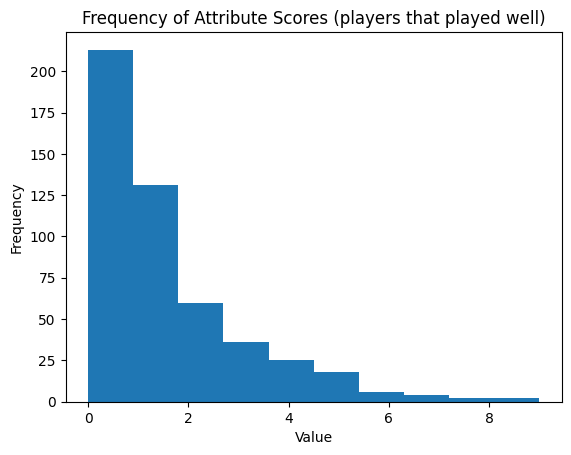

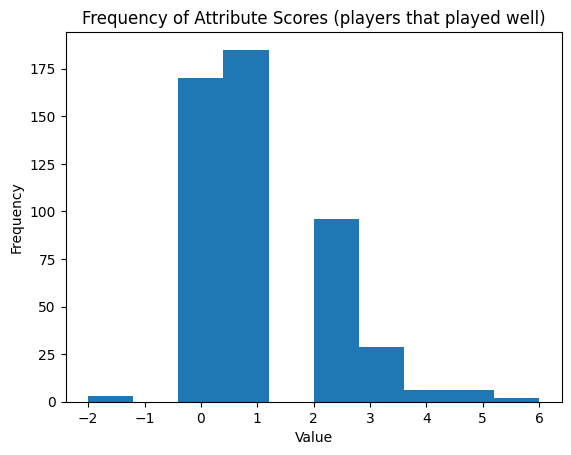

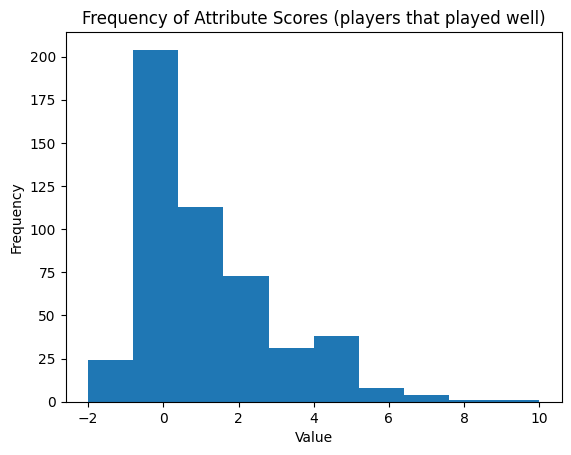

In [44]:
attributes = ["Research", "Resourceful", "Endurance", "Tech", "Social", "Trust"]
final_values = []

for sublist in parsed_json_object_1:
    total_skill = {
        "Research": 0,
        "Resourceful": 0,
        "Endurance": 0,
        "Tech": 0,
        "Social": 0,
        "Trust": 0
    }
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value

    final_values.append(list(total_skill.values()))

for i, attribute in enumerate(attributes):
    plt.figure(i)
    plt.hist([values[i] for values in final_values])
    plt.title(attribute)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f'Frequency of Attribute Scores (players that played well)')


plt.show()

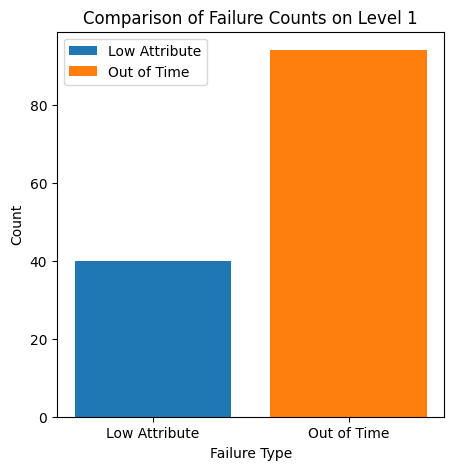

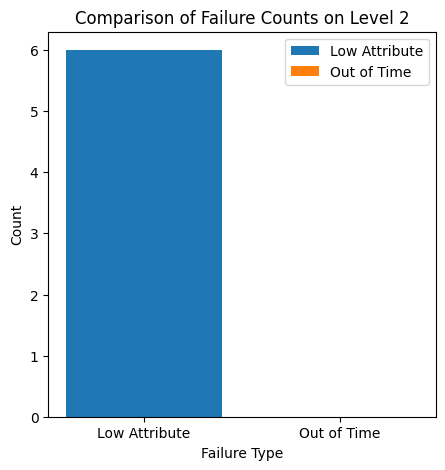

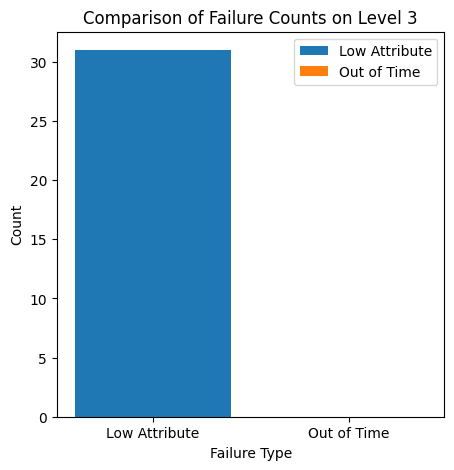

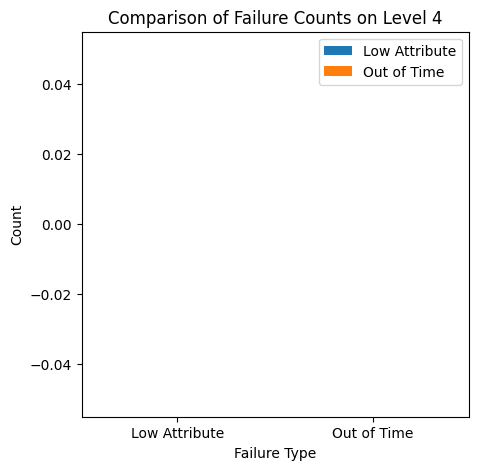

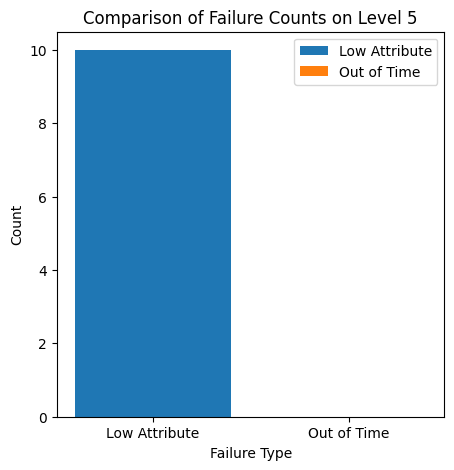

In [45]:
df_failure = df_session[df_session['TotalFails'] < 10]
def bar_graph(df_1, df_2, level):
  plt.figure(figsize=(5, 5))
  plt.bar('Low Attribute', df_1.sum(), label='Low Attribute')
  plt.bar('Out of Time', df_2.sum(), label='Out of Time')
  plt.xlabel('Failure Type')
  plt.ylabel('Count')
  plt.title(f'Comparison of Failure Counts on Level {level}')
  plt.legend()

  plt.show()

bar_graph(df_failure['lvl1_FailureCount-LowAttribute'], df_failure['lvl1_FailureCount-OutOfTime'], 1)
bar_graph(df_failure['lvl2_FailureCount-LowAttribute'], df_failure['lvl2_FailureCount-OutOfTime'], 2)
bar_graph(df_failure['lvl3_FailureCount-LowAttribute'], df_failure['lvl3_FailureCount-OutOfTime'], 3)
bar_graph(df_failure['lvl4_FailureCount-LowAttribute'], df_failure['lvl4_FailureCount-OutOfTime'], 4)
bar_graph(df_failure['lvl5_FailureCount-LowAttribute'], df_failure['lvl5_FailureCount-OutOfTime'], 5)

In [46]:
df_session[df_session['SkillSequenceCount-Event Sequence'] != '[]']

,PlayerID,SessionCount,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,QuitType-BetweenLevels,QuitType-OnFail,QuitType-OnCheckpoint,QuitType-Other,SkillSequenceCount,SkillSequenceCount-Event Sequence,TopAttribute,TopAttribute-Names,TotalFails,WorstAttribute,WorstAttribute-Names,lvl1_AttributeView,lvl2_AttributeView,lvl3_AttributeView,lvl4_AttributeView,lvl5_AttributeView,lvl1_EditorNoteOpen,lvl2_EditorNoteOpen,lvl3_EditorNoteOpen,lvl4_EditorNoteOpen,lvl5_EditorNoteOpen,lvl1_FailureCount,lvl1_FailureCount-OutOfTime,lvl1_FailureCount-LowAttribute,lvl2_FailureCount,lvl2_FailureCount-OutOfTime,lvl2_FailureCount-LowAttribute,lvl3_FailureCount,lvl3_FailureCount-OutOfTime,lvl3_FailureCount-LowAttribute,lvl4_FailureCount,lvl4_FailureCount-OutOfTime,lvl4_FailureCount-LowAttribute,lvl5_FailureCount,lvl5_FailureCount-OutOfTime,lvl5_FailureCount-LowAttribute,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete,UserPlayTime,UserPlayTime-Total Time
2,EnoughRally,1,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,0,1,0,0,16,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":0,...",5,['tech'],2,1,['research'],1,4,1,1,3,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0.229,0.800,0.633,0.340,0.0,1,0,5238.172,5238.172
3,SmartestIcicle,1,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,0,0,0,1,15,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",5,['tech'],1,0,['research'],0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.031,0.559,0.300,0.000,0.0,1,0,4932.518,4932.518
4,QuickFax,1,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,0,0,0,1,1,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",2,"['resourceful', 'tech']",0,1,"['endurance', 'social', 'trust', 'research']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0,0,182.732,182.732
5,CirclingPencil,3,"[1,4,7,2,3,7]",6,change_background_image,@0C9004F8,BetweenLevels,1,0,0,0,15,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",7,"['tech', 'research']",0,1,['endurance'],2,2,2,1,3,1,2,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.040,0.350,0.189,0.340,0.0,0,1,3995.716,4733.391
6,FlawlessTopic,3,"[1,4,5,6,2,0]",6,change_background_image,@0C9004F8,Other,0,0,0,1,19,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",6,['social'],2,0,['research'],0,3,0,2,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,-0.173,0.300,0.633,0.000,0.0,2,1,5490.609,7781.263
8,ResidentDish,1,"[3,4,3,3,3,3]",2,open_map_tab,none,Other,0,0,0,1,1,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",4,['resourceful'],0,3,"['endurance', 'tech', 'social', 'trust', 'rese...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.134,0.000,0.000,0.000,0.0,0,0,488.806,488.806
9,GlassVine,1,"[1,3,1,2,2,1]",1,display_text_dialog,@0C9004F8,Other,0,0,0,1,3,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",3,['resourceful'],0,1,"['endurance', 'tech', 'research']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0,0,1048.642,1048.642
10,CrustyFuture,1,"[2,1,2,1,2,2]",0,stat_update,@0C9004F8,Other,0,0,0,1,2,"[{""skill"": ""{\""Research\"":1,\""Resourceful\"":0,...",2,"['endurance', 'tech', 'trust', 'research']",0,1,"['resourceful', 'social']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0,0,152.016,152.016
11,SteelyFiesta,1,"[1,1,1,1,2,2]",0,display_text_dialog,@0C9004F8,Other,0,0,0,1,1,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":0,...",2,"['trust', 'research']",0,1,"['endurance', 'resourceful', 'tech', 'social']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0,0,162.030,162.030
12,FeatheryHello,1,"[1,1,2,1,3,3]",0,display_text_dialog,@0C9004F8,Other,0,0,0,1,2,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":0,...",3,"['trust', 'research']",0,1,"['endurance', 'resourceful', 'social']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000

In [58]:
# choose which user you want to look at, change index at the end
json_string = df_session['SkillSequenceCount-Event Sequence'][2]

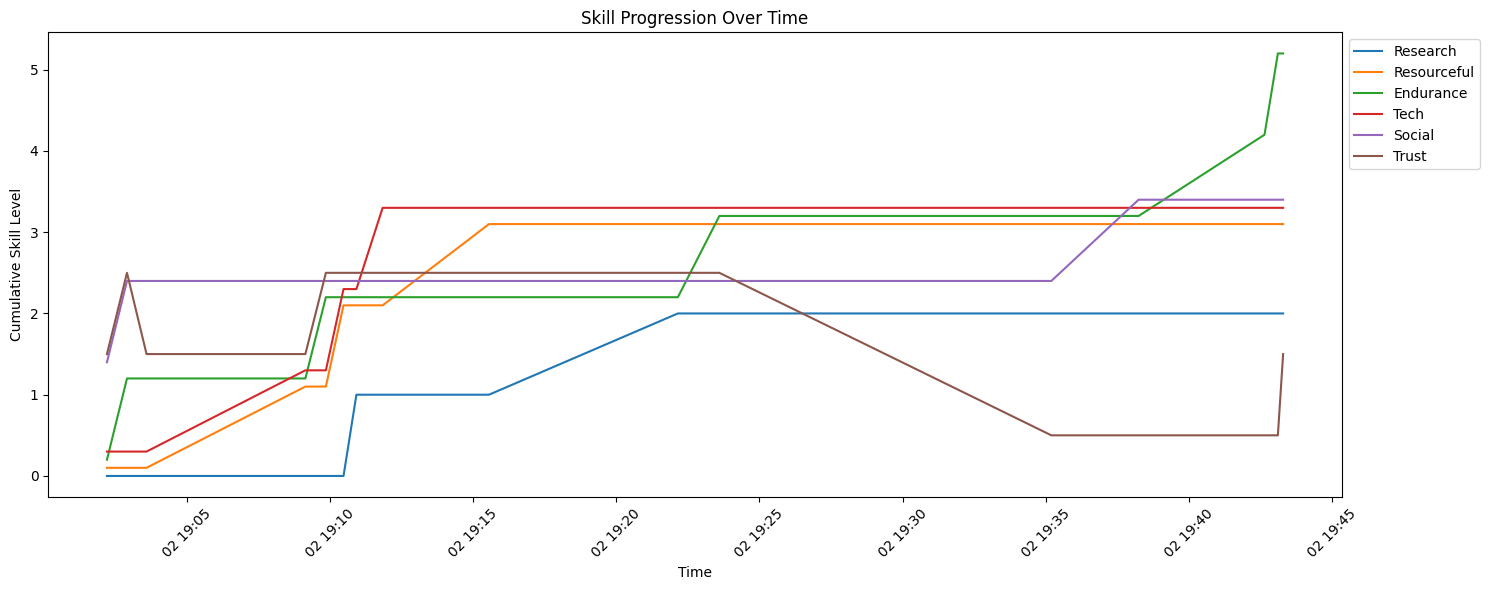

Final Scores: {'Research': 2.0, 'Resourceful': 3.1, 'Endurance': 5.2, 'Tech': 3.3, 'Social': 3.4, 'Trust': 1.5}


In [60]:
data = json.loads(json_string)
skill_names = ["Research", "Resourceful", "Endurance", "Tech", "Social", "Trust"]

skill_data = {skill_name: {"time": [], "level": []} for skill_name in skill_names}

cumulative_levels = {skill_name: 0.1 * i for i, skill_name in enumerate(skill_names)}

for item in data:
    time = parser.parse(item["time"])
    skill_values = json.loads(item["skill"])

    for skill_name, level in skill_values.items():
        cumulative_levels[skill_name] += level
        skill_data[skill_name]["time"].append(time)
        skill_data[skill_name]["level"].append(cumulative_levels[skill_name])

plt.figure(figsize=(15, 6))
plt.title("Skill Progression Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Skill Level")

for skill_name, skill_values in skill_data.items():
    plt.plot(skill_values["time"], skill_values["level"], label=skill_name)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



print(f'Final Scores: {cumulative_levels}')

In [49]:
[{"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":1,\"Trust\":1}", "time": "2023-04-02 19:02:12", "index": 0},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":1,\"Tech\":0,\"Social\":1,\"Trust\":1}", "time": "2023-04-02 19:02:54", "index": 1},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":-1}", "time": "2023-04-02 19:03:35", "index": 2},
 {"skill": "{\"Research\":0,\"Resourceful\":1,\"Endurance\":0,\"Tech\":1,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:09:08", "index": 3},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":1,\"Tech\":0,\"Social\":0,\"Trust\":1}", "time": "2023-04-02 19:09:51", "index": 4},
 {"skill": "{\"Research\":0,\"Resourceful\":1,\"Endurance\":0,\"Tech\":1,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:10:28", "index": 5},
 {"skill": "{\"Research\":1,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:10:55", "index": 6},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":1,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:11:50", "index": 7},
 {"skill": "{\"Research\":0,\"Resourceful\":1,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:15:33", "index": 8},
 {"skill": "{\"Research\":1,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:22:09", "index": 9},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":1,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:23:36", "index": 10},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":-2}", "time": "2023-04-02 19:35:12", "index": 11},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":1,\"Trust\":0}", "time": "2023-04-02 19:38:15", "index": 12},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":1,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:42:39", "index": 13},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":1,\"Tech\":0,\"Social\":0,\"Trust\":0}", "time": "2023-04-02 19:43:07", "index": 14},
 {"skill": "{\"Research\":0,\"Resourceful\":0,\"Endurance\":0,\"Tech\":0,\"Social\":0,\"Trust\":1}", "time": "2023-04-02 19:43:18", "index": 15}]
 #             Research:  2   Resourceful:  3   Endurance:  5   Tech:  3   Social:  3   Trust:  1

[{'skill': '{"Research":0,"Resourceful":0,"Endurance":0,"Tech":0,"Social":1,"Trust":1}',
  'time': '2023-04-02 19:02:12',
  'index': 0},
 {'skill': '{"Research":0,"Resourceful":0,"Endurance":1,"Tech":0,"Social":1,"Trust":1}',
  'time': '2023-04-02 19:02:54',
  'index': 1},
 {'skill': '{"Research":0,"Resourceful":0,"Endurance":0,"Tech":0,"Social":0,"Trust":-1}',
  'time': '2023-04-02 19:03:35',
  'index': 2},
 {'skill': '{"Research":0,"Resourceful":1,"Endurance":0,"Tech":1,"Social":0,"Trust":0}',
  'time': '2023-04-02 19:09:08',
  'index': 3},
 {'skill': '{"Research":0,"Resourceful":0,"Endurance":1,"Tech":0,"Social":0,"Trust":1}',
  'time': '2023-04-02 19:09:51',
  'index': 4},
 {'skill': '{"Research":0,"Resourceful":1,"Endurance":0,"Tech":1,"Social":0,"Trust":0}',
  'time': '2023-04-02 19:10:28',
  'index': 5},
 {'skill': '{"Research":1,"Resourceful":0,"Endurance":0,"Tech":0,"Social":0,"Trust":0}',
  'time': '2023-04-02 19:10:55',
  'index': 6},
 {'skill': '{"Research":0,"Resourceful":